# Imports and Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
X = np.vstack((
    np.array([1, 1]) + np.random.rand(10, 2),
    np.array([1, -1]) + np.random.rand(10, 2),
    np.array([-1, -1]) + np.random.rand(10, 2),
    np.array([-1, 1]) + np.random.rand(10, 2),
))
y_ally = np.vstack((np.ones((10, 1)), np.ones((10, 1)), np.zeros((10, 1)), np.zeros((10, 1))))
y_advr = np.vstack((np.ones((10, 1)), np.zeros((10, 1)), np.zeros((10, 1)), np.ones((10, 1))))

X.shape, y_ally.shape, y_advr.shape

((40, 2), (40, 1), (40, 1))

# Utility

In [3]:
def class_plot(X_input, aspect=True, title=False, orig=True, save=False):
    X_tsne = TSNE(n_components=2).fit_transform(X_input)
    X_pca = PCA(n_components=2).fit_transform(X_input)
    colors = ['r', 'b']
    markers = ['o', 'x', 'o', 'x']
    
    if orig:
        fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5))
        t3, t1, t2 = '(a)', '(b)', '(c)'
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
        t1, t2 = '(a)', '(b)'
    if orig:
        for i in range(2):
            for j in range(2):
                tmp = X_input[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
                ax3.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
        ax3.axis('equal')
        ax3.set_title(t3, y=-0.2)

    for i in range(2):
        for j in range(2):
            tmp = X_pca[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax1.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax1.axis('equal')
    ax1.set_title(t1, y=-0.2)

    for i in range(2):
        for j in range(2):
            tmp = X_tsne[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax2.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax2.axis('equal')
    ax2.set_title(t2, y= -0.2)
    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()

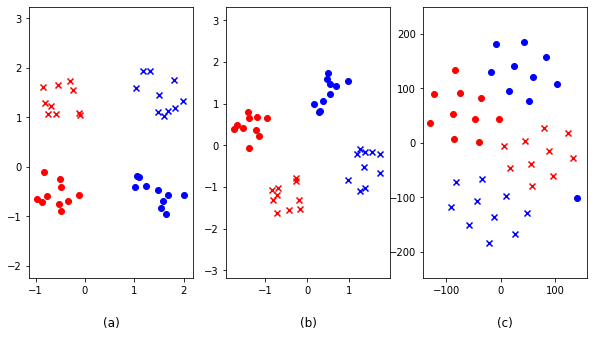

In [4]:
class_plot(X)

### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [213]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

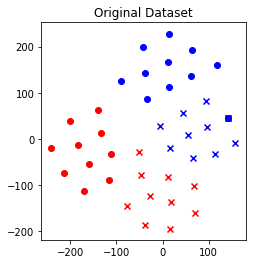

In [147]:
class_plot(X_normalized, title="Original Dataset")

# PCA

In [148]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

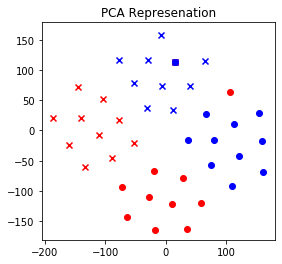

In [149]:
class_plot(X_pca, title='PCA Represenation')

# AutoEncoder

In [150]:
import torch

In [151]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        self.hidden_size = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        self.fc11 = torch.nn.Linear(self.hidden_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
        self.fc22 = torch.nn.Linear(self.hidden_size, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.sigmoid(self.fc11(self.sigmoid(self.fc1(x))))

    def decoder(self, y):
        return self.sigmoid(self.fc22(self.sigmoid(self.fc2(y))))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [152]:
auto_encoder = AutoEncoder(
    input_size=X_normalized.shape[1],
    encoding_dim=X_normalized.shape[1], 
    hidden_size=X_normalized.shape[1]*2
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.01)

In [238]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_torch = torch.Tensor(y_advr.reshape(-1, 1))

epoch 	 Aencoder_train
0 	 0.12978962
1000 	 0.00325056
2000 	 0.00085405
3000 	 0.00046968
4000 	 0.00024013
5000 	 0.00016424
6000 	 0.00014550
7000 	 0.00013712
8000 	 0.00013093
9000 	 0.00012689
10000 	 0.00012398


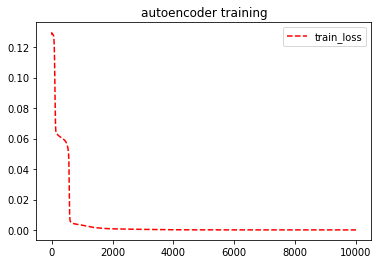

In [154]:
print("epoch \t Aencoder_train")

ae_epoch = []
ae_train = []

for epoch in range(10001):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_torch_hat = auto_encoder(X_torch)
    ae_loss = criterion(X_torch_hat, X_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
    ))
    

plt.plot(ae_epoch, ae_train, 'r--')
plt.legend(['train_loss'])
plt.title("autoencoder training")
plt.show()

In [155]:
X_autoencoded = auto_encoder.encoder(X_torch)

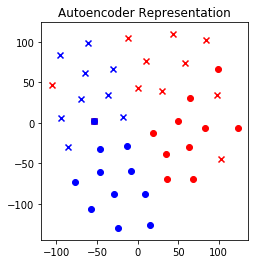

In [156]:
class_plot(X_autoencoded.detach().numpy(), title='Autoencoder Representation')

In [157]:
X_autodecoded = auto_encoder.decoder(X_autoencoded)

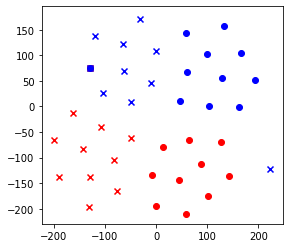

In [158]:
class_plot(X_autodecoded.detach().numpy())

# Privacy GAN

In [248]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.tanh(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.batchnorm = torch.nn.BatchNorm1d(self.hidden_size)
    def forward(self, x):
        hidden = self.fc1(x)
#         hidden = self.batchnorm(hidden)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [354]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_pca.shape[1]
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*4, 
        output_size=encoding_dimension*2)
    ally = Ally(
        input_size=encoding_dimension*2, 
        hidden_size=encoding_dimension*2, 
        output_size=y_ally_torch.shape[1])
    adversary = Adversary(
        input_size=encoding_dimension*2, 
        hidden_size=encoding_dimension*4, 
        output_size=y_advr_torch.shape[1])

    criterion = torch.nn.BCEWithLogitsLoss()
    kldiv = torch.nn.KLDivLoss()
    l1_loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_train = []
    
    encoder.train()
    ally.train()
    adversary.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_torch_hat = adversary(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
#         advr_loss = -criterion(y_advr_torch_hat, y_advr_torch)
        advr_loss = (20 - l1_loss(y_advr_torch_hat, y_advr_torch))/20
        encd_loss = alpha * ally_loss + (1 - alpha) * advr_loss
        # Backward pass kldiv(torch.log(y_advr_torch_hat), y_uniform_torch) 
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_torch_hat = adversary(X_ganencoded)
            advr_optimizer.zero_grad()
            advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
            advr_loss.backward()
            advr_optimizer.step()

        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_train.append(advr_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False, orig=False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_train, 'g')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr train loss',
        ])
        
        plt.xlabel('number of iterations')
        plt.ylabel('loss')
        plt.show() 

        return encoder  

- maximize the divergence
- no dimensionality reduction here

epoch 	 encoder_train 	 ally_train 	 advr_train
0 	 0.86043191 	 0.73832685 	 0.73125857


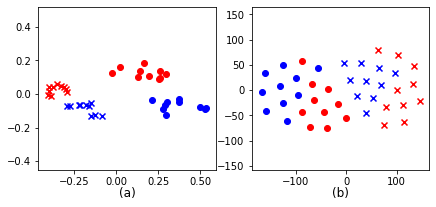

500 	 0.75050676 	 0.52601367 	 0.69400227


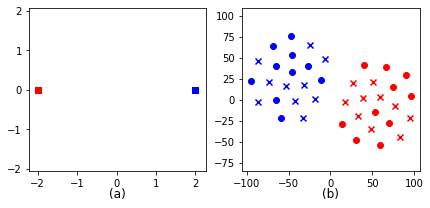

1000 	 0.74125934 	 0.50751889 	 0.69331121


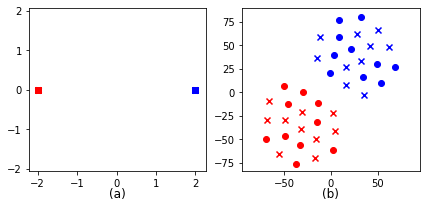

1500 	 0.73992980 	 0.50486940 	 0.69328105


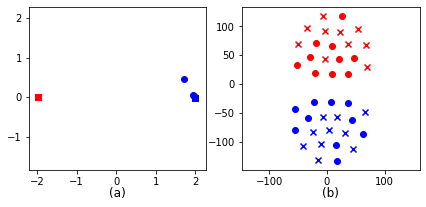

2000 	 0.73951817 	 0.50404441 	 0.69324088


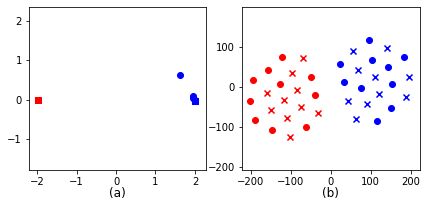

2500 	 0.73934305 	 0.50369149 	 0.69320834


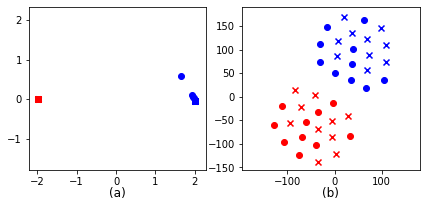

3000 	 0.73925316 	 0.50351006 	 0.69318891


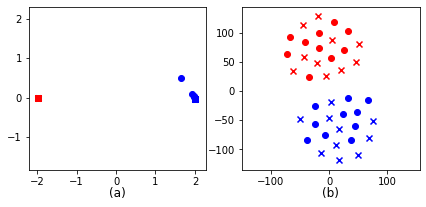

3500 	 0.73920166 	 0.50340629 	 0.69317985


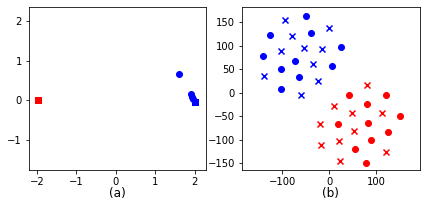

4000 	 0.73917019 	 0.50334185 	 0.69316405


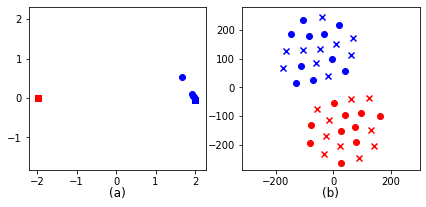

4500 	 0.73914981 	 0.50330061 	 0.69315916


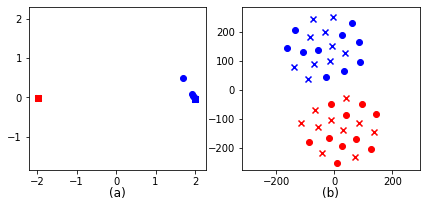

5000 	 0.73913622 	 0.50327313 	 0.69315577


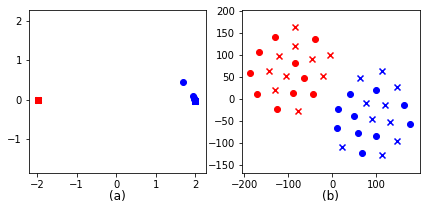

5500 	 0.73912680 	 0.50325429 	 0.69315475


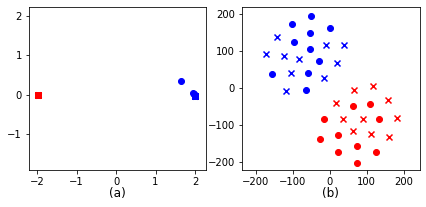

6000 	 0.73912013 	 0.50324070 	 0.69315213


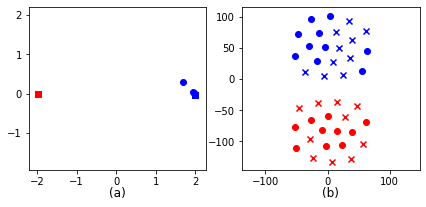

6500 	 0.73911548 	 0.50323117 	 0.69315082


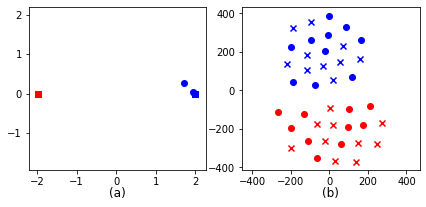

7000 	 0.73911214 	 0.50322443 	 0.69314969


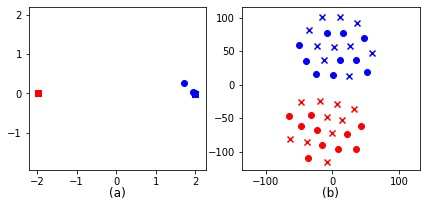

7500 	 0.73910952 	 0.50321925 	 0.69314903


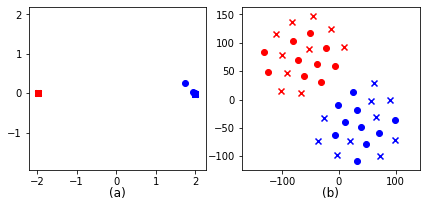

8000 	 0.73910767 	 0.50321543 	 0.69314843


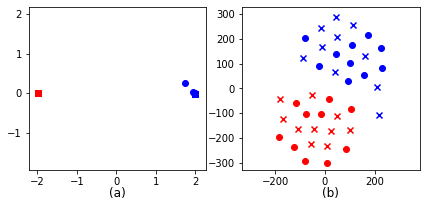

8500 	 0.73910636 	 0.50321281 	 0.69314820


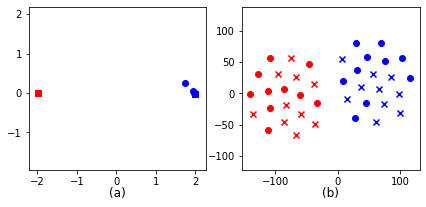

9000 	 0.73910534 	 0.50321072 	 0.69314814


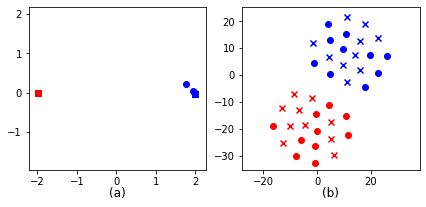

9500 	 0.73910451 	 0.50320905 	 0.69314772


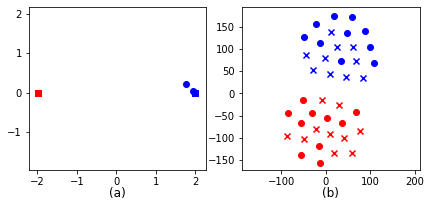

10000 	 0.73910397 	 0.50320792 	 0.69314760


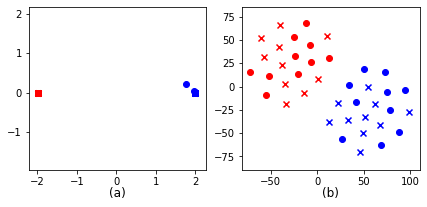

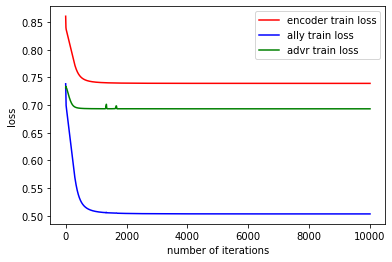

In [355]:
alpha = 0.5
lr_encd = 0.1
lr_ally = 0.001
lr_advr = 0.001
n_iter_gan = 10001
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

# Training Independently

In [88]:
encoding_dimension = 2
encoder.eval()

Encoder(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [89]:
ally = Ally(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_ally_torch.shape[1])
criterion = torch.nn.BCEWithLogitsLoss()
ally_optimizer = optimizer(ally.parameters(), lr=0.01)

print("epoch \t ally_train")

ally.train()

n_iter = 10001
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_ally_torch_hat = ally(X_ganencoded)
    ally_optimizer.zero_grad()
    ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
    ally_loss.backward()
    ally_optimizer.step()
    
    if epoch%1000!=0:
        continue

    print('{} \t {:.8f}'.format(
        epoch, 
        ally_loss.item(),
    ))
    

epoch 	 ally_train
0 	 0.75935817
1000 	 0.50519240
2000 	 0.50378525
3000 	 0.50345957
4000 	 0.50333524
5000 	 0.50327659
6000 	 0.50324571
7000 	 0.50322872
8000 	 0.50321895
9000 	 0.50321311
10000 	 0.50320959


In [90]:
adversary = Adversary(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_advr_torch.shape[1])

advr_optimizer = optimizer(adversary.parameters(), lr=0.01)

print("epoch \t advr_train")

adversary.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_torch_hat = adversary(X_ganencoded)
    advr_optimizer.zero_grad()
    advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
    advr_loss.backward()
    advr_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_loss.item(),
    ))
    

epoch 	 advr_train
0 	 0.72458750
1000 	 0.69315189
2000 	 0.69314736
3000 	 0.69314641
4000 	 0.69314587
5000 	 0.69314539
6000 	 0.69314474
7000 	 0.69314259
8000 	 0.69287205
9000 	 0.68507183
10000 	 0.68361628


# DP

In [ ]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

In [ ]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [ ]:
np.random.laplace(0, 1.0/100000, X_dp.shape)